In [1]:
%%capture
!pip install "dlt[sql_database, duckdb]"
!pip install pymysql
!pip install pyyaml

# **Logging and Tracing**
In this chapter we will learn how to use dlt's trace method to debug pipeline issues



In [2]:
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator
import os
from google.colab import userdata

os.environ["SOURCES__SECRET_KEY"] = userdata.get('SECRET_KEY')

@dlt.source
def github_source(secret_key=dlt.secrets.value):
    client = RESTClient(
            base_url="https://api.github.com",
            auth=BearerTokenAuth(token=secret_key),
            paginator=HeaderLinkPaginator(),
    )

    @dlt.resource
    def github_pulls(cursor_date=dlt.sources.incremental("updated_at", initial_value="2024-12-01")):
        params = {
            "since": cursor_date.last_value,
            "status": "open"
        }
        for page in client.paginate("repos/dlt-hub/dlt/pulls", params=params):
            yield page


    return github_pulls


# define new dlt pipeline
pipeline = dlt.pipeline(
    pipeline_name="github_pipeline",
    destination="duckdb",
    dataset_name="github_data",
)


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)


Pipeline github_pipeline load step completed in 1.14 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data
Load package 1746216346.0049639 is LOADED and contains no failed jobs


In [3]:
import duckdb

conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")

conn.sql("SHOW ALL TABLES").df()

,database,schema,name,column_names,column_types,temporary
0,github_pipeline,github_data,_dlt_loads,"[load_id, schema_name, status, inserted_at, sc...","[VARCHAR, VARCHAR, BIGINT, TIMESTAMP WITH TIME...",False
1,github_pipeline,github_data,_dlt_pipeline_state,"[version, engine_version, pipeline_name, state...","[BIGINT, BIGINT, VARCHAR, VARCHAR, TIMESTAMP W...",False
2,github_pipeline,github_data,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
3,github_pipeline,github_data,github_pulls,"[url, id, node_id, html_url, diff_url, patch_u...","[VARCHAR, BIGINT, VARCHAR, VARCHAR, VARCHAR, V...",False
4,github_pipeline,github_data,github_pulls__assignees,"[login, id, node_id, avatar_url, gravatar_id, ...","[VARCHAR, BIGINT, VARCHAR, VARCHAR, VARCHAR, V...",False
5,github_pipeline,github_data,github_pulls__base__repo__topics,"[value, _dlt_parent_id, _dlt_list_idx, _dlt_id]","[VARCHAR, VARCHAR, BIGINT, VARCHAR]",False
6,github_pipeline,github_data,github_pulls__head__repo__topics,"[value, _dlt_parent_id, _dlt_list_idx, _dlt_id]","[VARCHAR, VARCHAR, BIGINT, VARCHAR]",False
7,github_pipeline,github_data,github_pulls__labels,"[id, node_id, url, name, color, default, descr...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, VARCHAR, B...",False
8,github_pipeline,github_data,github_pulls__requested_reviewers,"[login, id, node_id, avatar_url, gravatar_id, ...","[VARCHAR, BIGINT, VARCHAR, VARCHAR, VARCHAR, V...",False


In [4]:
conn.sql("select * from github_data._dlt_loads").df()

,load_id,schema_name,status,inserted_at,schema_version_hash
0,1746216346.0049639,github_source,0,2025-05-02 20:05:48.184166+00:00,PFX9VoFpCl/AA3bY+A/mM1b/6V67woKy33y30GOZQLw=


## **1. Tracing with Sentry**

You can use Tracing with Sentry - an open-source error tracking and performance monitoring tool

In [5]:
%%capture
!pip install sentry-sdk

In [19]:
import sentry_sdk
import time

os.environ["RUNTIME__SENTRY_DSN"] = userdata.get("SENTRY_DSN")

sentry_sdk.init(
    dsn= os.environ.get("RUNTIME__SENTRY_DSN"),
    # Add data like request headers and IP for users,
    # see https://docs.sentry.io/platforms/python/data-management/data-collected/ for more info
    send_default_pii=True,
    # Set traces_sample_rate to 1.0 to capture 100% of transactions for performance monitoring
    traces_sample_rate=1.0,
    # Adjust this value in production based on your needs
    profiles_sample_rate=1.0
)

In [15]:
try:
    # Your code goes here
    print("Running your application...")

    # Example of triggering an error
    simulate_error = True
    if simulate_error:
        # This will be caught by Sentry
        1 / 0

except Exception as e:
    # Capture the exception
    sentry_sdk.capture_exception(e)
    print(f"Error captured and sent to Sentry: {e}")

Running your application...
Error captured and sent to Sentry: division by zero


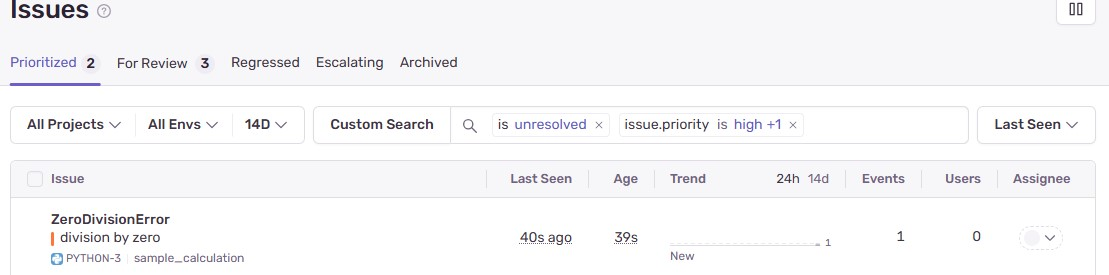

- To enable sentry with dlt you can either set the DSN in config.toml or via ENV vars

```
[runtime]

sentry_dsn="https:///<...>"
```

```
os.environ["RUNTIME__SENTRY_DSN"] ="https:<you dsn here>"
```


In [21]:
import os
from google.colab import userdata

os.environ['RUNTIME__SENTRY_DSN'] = userdata.get('SENTRY_DSN')

In [22]:
data = {
    12: 34
}

# lets trigger an issue in sentry

info = pipeline.run([data], table_name='issues')
info

LoadInfo(pipeline=<dlt.pipeline.pipeline.Pipeline object at 0x78fe02fe7610>, metrics={'1746218238.0815747': [{'started_at': DateTime(2025, 5, 2, 20, 37, 18, 202781, tzinfo=Timezone('UTC')), 'finished_at': DateTime(2025, 5, 2, 20, 37, 18, 318445, tzinfo=Timezone('UTC')), 'job_metrics': {'issues.1376bb8843.insert_values': LoadJobMetrics(job_id='issues.1376bb8843.insert_values', file_path='/var/dlt/pipelines/github_pipeline/load/normalized/1746218238.0815747/started_jobs/issues.1376bb8843.0.insert_values', table_name='issues', started_at=DateTime(2025, 5, 2, 20, 37, 18, 290621, tzinfo=Timezone('UTC')), finished_at=DateTime(2025, 5, 2, 20, 37, 18, 297897, tzinfo=Timezone('UTC')), state='completed', remote_url=None)}}]}, destination_type='dlt.destinations.duckdb', destination_displayable_credentials='duckdb:////content/github_pipeline.duckdb', destination_name='duckdb', environment=None, staging_type=None, staging_name=None, staging_displayable_credentials=None, destination_fingerprint='', 

## **2. Logging**

### Setting Logging Levels in dlt

1. You can set log levels in your config.toml file:

```
[runtime]
log_level="INFO"
```

log_level accepts the Python standard logging level names.

The default log level is WARNING.

`INFO` log level is useful when diagnosing problems in production.

`CRITICAL` will disable logging.

`DEBUG` should not be used in production.


2. Setting as ENV VAR

```python
import os
os.environ['RUNTIME__LOG_LEVEL'] = 'INFO'
```

In [23]:
import os
os.environ['RUNTIME__LOG_LEVEL'] = 'INFO'

In [24]:
import logging

# Create a logger - dlt logs to a logger named dlt
logger = logging.getLogger('dlt')

# Set the log level
logger.setLevel(logging.INFO)

# Create a file handler
handler = logging.FileHandler('dlt.log')

# Add the handler to the logger
logger.addHandler(handler)

# USING LOGGER
pipeline = dlt.pipeline(
    pipeline_name="github_issues_merge_logger",
    destination="duckdb",
    dataset_name="github_data_merge",
)
load_info = pipeline.run(github_source())

# result gets showed despite no print statement ? check dlt.log

2025-05-02 20:43:31,199|[INFO]|324|133033718951936|dlt|__init__.py|bind:482|Bind incremental on github_pulls with initial_value: 2024-12-01, start_value: 2024-12-01, end_value: None
2025-05-02 20:43:31,209|[INFO]|324|133033718951936|dlt|client.py|_send_request:127|Making GET request to https://api.github.com/repos/dlt-hub/dlt/pulls with params={'since': '2024-12-01', 'status': 'open'}, json=None with headers={}
2025-05-02 20:43:31,650|[INFO]|324|133033718951936|dlt|client.py|detect_data_selector:286|Detected page data at path: '$' type: list length: 30
2025-05-02 20:43:31,698|[INFO]|324|133033718951936|dlt|client.py|extract_response:267|Extracted data of type list from path $ with length 30
2025-05-02 20:43:31,775|[INFO]|324|133033718951936|dlt|client.py|_send_request:127|Making GET request to https://api.github.com/repositories/452221115/pulls?since=2024-12-01&status=open&page=2 with params=None, json=None with headers={}
2025-05-02 20:43:32,079|[INFO]|324|133033718951936|dlt|client.p